# Author: Midrar Adham
## Homework 2: Pinhole Camera geometry

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Inputs:

- I've taken two images of a checkerboard.
- The focal length is 1 ft and 22 inches.
- The horizontal axis difference between the two images is 11 inches

In [2]:
images = ['pattern_1', 'pattern_2']

def read_images (img):
    img = cv.imread(f'../../sample_data/{img}.jpg')
    return img

def para_plots(img1, img2):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    fig.tight_layout()
    ax[0].set_title('Original Image')
    ax[0].imshow(img1)
    ax[1].set_title('Modified Image')
    ax[1].imshow(img2)

**Choose a calibration target with points at known locations. This may be a checker board or anything else you wish to use. Include a picture of your calibration target**

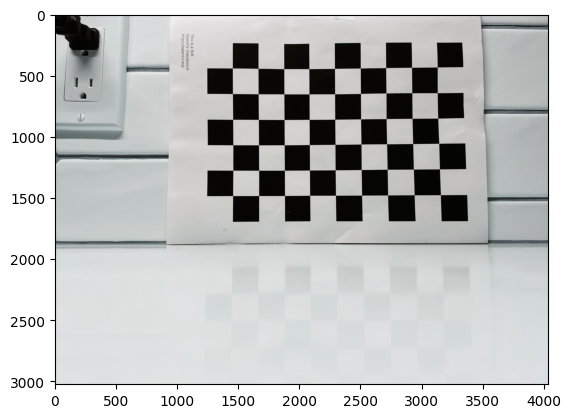

In [3]:
img = read_images(img = images[0])
plt.imshow(img)

**Explain your rationale for using this calibration target.**

- Clear pattern.
- Specified dimensions (6x9)
- Therefore, it is easy to process.

**Describe the known geometry of the calibration target. What are the positions of the known points on the target?**

- The corners of the checkerboard are known.
- The beginning and ending coordinates of each square are known.
    - The checkerboard has 9 rows and 6 columns.

**Use the calibration target to estimate the camera intrinsic parameters (and preferably the distortion parameters). Write the results of the calibration for the intrinsic camera parameters.**

In [4]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

'''
The objp variable is very confusing. Here is a brief explaination. 

1- To calculate the projection matrix, we need 2D coordinates and 3D coordinates.
2- The 2D coordinates can be easily found using openCV method (findchessboardCorners)
3- The 3D coordinates, however, needs some pre-defined variables.
    3A- Create a matrix with the size of the your checkerboard image.
    3B- This matrix may contain just zeroes. It does not matter. These points will be updated later.
    3C- The point is this matrix contains 54 rows and three columns. Each column is x,y, and z of the
    world coordinates frame.
    4D- The next line generates a grid of 2D points. This grid is then mapped to the previously created array
    without the z-axis. Since this is a flat image, the z-axis will remain zero.
'''

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

world_3d_points = []
img_plane_2d_points = []

for img in images:
    image = read_images(img=img)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Find the chessboard corners
    corners_found, corners = cv.findChessboardCorners(image = gray, patternSize=(9,6), flags=None)

    if corners_found == True:
        world_3d_points.append(objp)
        corners2 = cv.cornerSubPix(image=gray,
                                   corners=corners,
                                   winSize=(11,11),
                                   zeroZone=(-1,-1), # A neglected zone. The -1,-1 is like None.
                                   criteria=criteria
                                   ) # more accurate corners (in subpixels)
        
        img_plane_2d_points.append(corners)
        cv.drawChessboardCorners(image=image, patternSize=(9,6), corners=corners2, patternWasFound=corners_found)
        # plt.imshow(image)
        # plt.show()
image_size = gray.shape[::-1]
reprojection_error, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv.calibrateCamera(world_3d_points,
                                                                                                                       img_plane_2d_points,
                                                                                                                       image_size,
                                                                                                                       None,
                                                                                                                       None
                                                                                                                       )

print(f'reprojection_error = \n{reprojection_error}\n')
print(f'camera_matrix = \n{camera_matrix}\n')
print(f'\ndistortion_coefficients = \n{distortion_coefficients}\n')


reprojection_error = 
1.6273415865923846

camera_matrix = 
[[4.85213517e+03 0.00000000e+00 1.96688017e+03]
 [0.00000000e+00 4.84641657e+03 1.32939425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


distortion_coefficients = 
[[ 8.57989302e-01 -1.24449907e+01 -1.16085631e-02  6.26083478e-03
   6.72786535e+01]]



**Describe how you performed the intrinsic estimation, and your rationale for doing so. If using a function in a software package, explain in mathematical terms what the package does.**

# This is not for submission. It is here to get a good grasp of things:

- The returned camera matrix contains only the intrinsic parameters of the camera.
- The extrinsic parameters are returned from the ```rotation_vectors``` $\&$ ```translation_vectors``` variables.

### Interpertations of the returned values of the ```caliberateCamera()``` method:

The ```camera_matrix``` contains the following values:

$$
\Lambda =
\begin{equation*}
\begin{bmatrix}
f_{x} & 0 & c_{x}\\
0 & f_{y} & c_{y}\\
0 & 0 & 1
\end{bmatrix}
\end{equation*}
$$

Where:

- The $f_{x}$ and $f_{y}$ are the focal length coordinates. 
- The $c_{x}$ and $c_{y}$ are the optical center coordinates.

Both of the $f$ and $c$ are the **intrinsic parameters** ($\Lambda$) of the camera. This matrix (1) can be mapped to the output produced by the ```caliberateCamera()``` method, such that:

$$
\Lambda =
\begin{bmatrix}

4.8521e+3 & 0.0 & 1.9668e+3\\
0.0 & 4.8464e+3 & 1.3293e+3\\
0.0 & 0.0 & 1.0

\end{bmatrix}
$$

Now we know the intrinsic parameters of the camera, let's look into the extrinsic parameters of the camera. The ```caliberateCamera``` method retruns the rotation and translation vectors. These two vectors form the **extrinsic parameters** of the camera. The extrinsic matrix contains the rotation ($\Omega$) and translation ($\tau$) vectors. The extrinsic matrix contains the following:

- Rotation matrix:
$$

\Omega = 
\begin{equation*}
\begin{bmatrix}
r_{11} & r_{12} & r_{13}\\
r_{21} & r_{22} & r_{23}\\
r_{31} & r_{32} & r_{33}
\end{bmatrix}
\end{equation*}
$$

- Translation matrix:
$$
\tau = 
\begin{equation*}
\begin{bmatrix}
t_{x}\\
t_{y}\\
t_{z}
\end{bmatrix}
\end{equation*}
$$

Both the $\Omega$ \& $\tau$ form the extrinsic matrix:

$$
\begin{equation*}
\begin{bmatrix}

r_{11} & r_{12} & r_{13} & t_{x}\\
r_{21} & r_{22} & r_{23} & t_{y}\\
r_{31} & r_{32} & r_{33} & t_{z}\\
0 & 0 & 0 & 1

\end{bmatrix}
\end{equation*}
$$


Given the output we obtained from the ```caliberateCamera``` method, we can re-write the extrinsic matrix as follows:

$$
\begin{equation*}
\begin{bmatrix}

-0.04732 & 0.1718 & 3.1305 & 5.5804\\
0.04823 & 0.1918 & 3.1294 & t_{y}\\
r_{31} & r_{32} & r_{33} & t_{z}\\
0 & 0 & 0 & 1

\end{bmatrix}
\end{equation*}
$$

**Perform extrinsic calibration. Explain how you did this, and your rationale for doing so.**

In [5]:
print(f'rotation_vectors = \n{rotation_vectors}\n')
print(f'translation_vectors = \n{translation_vectors}\n')

rotation_vectors = 
(array([[-0.04732454],
       [ 0.17186174],
       [ 3.1305271 ]]), array([[0.04822829],
       [0.19176218],
       [3.12936636]]))

translation_vectors = 
(array([[ 5.58049821],
       [ 0.72613145],
       [23.38267552]]), array([[ 1.15543484],
       [ 0.82092339],
       [23.03462029]]))



**What is the reference system used for your world reference frame? Describe where the origin is, and the axes that establish the 3D Euclidean coordinate system.**

**3D world point estimation. Capture the location of the point for the camera at two known locations. Repeat this for several points. Include images from the camera side-by-side, with the coordinates of the point of interest indicated.**

**Compare the accuracy of the estimated point locations from the pixel coordinates of the two camera locations to the actual 3D locations of the points. How accurate were your estimates?**

**What did you learn from this assignment?**

**What questions, if any, do you have for me after completing this assignment?**